In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd
import country_converter as coco
from matplotlib import pyplot as plt
from itertools import cycle, islice

In [50]:
df_new = pd.read_csv("data/ismir/ismir_2024.csv")
df = pd.read_csv("data/ismir_all_papers_old.csv")

df = pd.concat([df, df_new])

#df["first_country"] = df["Authors with Affiliations"].apply(lambda x: x.split(";")[0].split("+")[1].split("|")[0].split(">")[1])
df['Affiliation country'] = df['Authors with Affiliations'].apply(lambda x: ', '.join([entry.split('>')[1] for entry in x.split(';')]))
df['Affiliation type'] = df['Authors with Affiliations'].apply(lambda x: ', '.join([entry.split('>')[-1] for entry in x.split(';')]))

i = 1000
print(df.iloc[i]['Authors with Affiliations'])
print(df.iloc[i]['Affiliation country'])
print(df.iloc[i]['Affiliation type'])

df.head(-5)


Dmitry Bogdanov+Universitat Pompeu Fabra>ESP>education;Perfecto Herrera+Universitat Pompeu Fabra>ESP>education
ESP, ESP
education, education


,Unnamed: 0,Authors,Title,Year,Link,Authors with Affiliations,Abstract,first_country,first_aff_cat,first_aff_cat_UN,title_tsne_2d,abstract_tsne_2d,title_tsne_3d,abstract_tsne_3d,title_umap_2d,abstract_umap_2d,title_umap_3d,abstract_umap_3d,Affiliation country,Affiliation type
0,0,Abhishek Singhi;Daniel G. Brown 0001,"On Cultural, Textual and Experiential Aspects ...",2014,https://doi.org/10.5281/zenodo.1417391,Abhishek Singhi+University of Waterloo>CAN>edu...,We study the impact of the presence of lyrics ...,CAN,education,Developed economies,"[53.423794, 9.334391]","[22.15455, 44.90381]","[9.204252, 25.371681, -13.159601]","[31.079086, 4.8100176, 18.627697]","[14.551972, 11.541909]","[4.2909646, 5.3676243]","[13.508952, 16.572449, 3.8798807]","[3.569485, 3.772377, 1.0774649]","CAN, CAN","education, education"
1,1,Li Su;Li-Fan Yu;Yi-Hsuan Yang,"Sparse Cepstral, Phase Codes for Guitar Playin...",2014,https://doi.org/10.5281/zenodo.1417215,Li Su+Academia Sinica>TWN>education;Li-Fan Yu+...,Automatic recognition of guitar playing techni...,TWN,education,Developing economies,"[-35.543446, -36.86114]","[-20.38326, 2.985434]","[-29.133354, -2.8083057, 11.402137]","[-18.295946, 2.101953, -3.3441098]","[6.780552, 8.597961]","[9.334556, 4.2113585]","[9.23955, 12.289181, 1.8490081]","[7.9379563, 4.476486, 0.36777982]","TWN, TWN, TWN","education, education, education"
2,2,Münevver Köküer;Peter Jancovic;Islah Ali-MacLa...,Automated Detection of Single- and Multi-Note ...,2014,https://doi.org/10.5281/zenodo.1415266,Münevver Köküer+Birmingham City University>GBR...,This paper presents an automatic system for th...,GBR,education,Developed economies,"[-25.29935, -16.698326]","[-12.280578, -28.091785]","[-16.099663, -9.15232, -2.5760114]","[7.472903, -10.932249, -10.450779]","[8.592401, 7.51735]","[10.572977, 2.5928094]","[10.346087, 13.20923, 0.010662999]","[9.511134, 3.896057, 0.60513353]","GBR, GBR, GBR, GBR","education, education, education, education"
3,3,Bob L. Sturm;Nick Collins,The Kiki-Bouba Challenge: Algorithmic Composit...,2014,https://doi.org/10.5281/zenodo.1416364,Bob L. Sturm+Aalborg University>DNK>education;...,We propose the “Kiki-Bouba Challenge” (KBC) fo...,DNK,education,Developed economies,"[6.292622, 52.91158]","[29.068872, 12.032931]","[35.689396, 4.281251, 5.1335664]","[-2.8847516, 6.838861, 16.753286]","[12.7149315, 5.583541]","[5.412889, 1.8387237]","[14.507492, 13.455761, 0.59345573]","[5.606055, 2.370339, 0.24744686]","DNK, GBR","education, education"
4,4,Aäron van den Oord;Sander Dieleman;Benjamin Sc...,Transfer Learning by Supervised Pre-training f...,2014,https://doi.org/10.5281/zenodo.1415890,A¨aron van den Oord+Ghent University>BEL>educa...,Very few large-scale music research datasets a...,BEL,education,Developed economies,"[-10.507733, -9.155411]","[-32.806053, 13.507464]","[-6.2515626, 18.35284, 14.6625595]","[4.758102, -2.5571613, -22.69154]","[11.276819, 10.620869]","[7.2932196, 5.2476335]","[11.2803545, 14.072373, 2.5759306]","[6.849769, 5.0016685, 1.467031]","BEL, BEL, BEL","education, education, education"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,113,Nithya Nadig Shikarpur;Krishna Maneesha Denduk...,Hierarchical Generative Modeling of Melodic Vo...,2024,https://doi.org/10.5281/zenodo.14877505,"Nithya Shikarpur+Mila, Quebec Artificial Intel...",Hindustani music is a performance-driven oral ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"CAN, CAN, CAN, GBR, CAN","company, company, company, company, company"
114,114,Haonan Chen;Jordan B. L. Smith;Janne Spijkerve...,SymPAC: Scalable Symbolic Music Generation Wit...,2024,https://doi.org/10.5281/zenodo.14877507,Haonan Chen+ByteDance Inc.>USA>company;Jordan ...,Progress in the task of symbolic music generat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"USA, GBR, USA, USA, USA, USA, HKG, USA","company, education, company, company, company,..."
115,115,Giovanni Bindi;Philippe Esling,Unsupervised Composable Representa

In [29]:
EDITIONS = ["2000", "2001", "2002", "2003", "2004",
            "2005", "2006", "2007", "2008", "2009", 
            "2010", "2011", "2012", "2013", "2014",
            "2015", "2016", "2017", "2018", "2019",
            "2020", "2021", "2022", "2023", "2024"]

COLOR_LIST = ['darkblue', 'mediumblue', 'cornflowerblue', 
              'darkred', 'red', 'tomato', 'lightsalmon']

print(df.shape)
print(df.columns)

(2318, 20)
Index(['conference_index', 'Authors', 'Title', 'Year', 'Link',
       'Authors with Affiliations', 'Abstract', 'first_country',
       'first_aff_cat', 'first_aff_cat_UN', 'title_tsne_2d',
       'abstract_tsne_2d', 'title_tsne_3d', 'abstract_tsne_3d',
       'title_umap_2d', 'abstract_umap_2d', 'title_umap_3d',
       'abstract_umap_3d', 'Affiliation country', 'Affiliation type'],
      dtype='object')


In [3]:
type_e = 0
type_f = 0
type_c = 0
type_ef = 0
type_ec = 0
type_fc = 0
type_efc = 0

type_lists = []

typeDict = {}
countryDict = {}

country_names = set()

for ed in EDITIONS:
    # print("###",ed)

    dfISMIRyear = df[df["Year"] == int(ed)]
    countryDict[ed] = {}

    for index, row in dfISMIRyear.iterrows():

        aff_types = [x.strip() for x in row["Affiliation type"].split(",")]
        aff_countries = [x.strip() for x in row["Affiliation country"].split(",")]

        # Check list lenghts
        it = iter([aff_types,aff_countries])
        the_len = len(next(it))
        if not all(len(l) == the_len for l in it):
             raise ValueError('not all lists have same length!')

        # Aff types
        if len(set(aff_types)) == 1:
            if "education" in aff_types:
                type_e += 1
            elif "facility" in aff_types:
                type_f += 1
            elif "company" in aff_types:
                type_c += 1
        elif len(set(aff_types)) == 2:
            if "education" in aff_types and "facility" in aff_types:
                type_ef += 1
            elif "education" in aff_types and "company" in aff_types:
                type_ec += 1
            elif "facility" in aff_types and "company" in aff_types:
                type_fc += 1
        elif len(set(aff_types)) == 3:
            type_efc += 1


        # Aff countries
        if len(set(aff_countries)) == 1:
            co = next(iter(set(aff_countries)))
            country_names.add(co)
            if co not in countryDict[ed]:
                countryDict[ed][co] = {"sc":1, "mc":0}
            else:
                countryDict[ed][co]["sc"] += 1
        else:
            for co in set(aff_countries):
                country_names.add(co)
                if co not in countryDict[ed]:
                    countryDict[ed][co] = {"sc":0, "mc":1}
                else:
                    countryDict[ed][co]["mc"] += 1



    type_list = [type_e, type_f, type_c, type_ef, type_ec, type_fc, type_efc]
    type_list_perc = [round(x*100/np.sum(type_list), 2) for x in type_list]

    typeDict[ed] = type_list_perc
    
    # print(type_list)
    # print(type_list_perc)
    # print(len(dfISMIRyear), len(countryDict[ed]))

CountryCountDict = {}
for co in country_names:
    if co == 'unknown':
        continue
    CountryCountDict[co] = [0,0]
    for ed in EDITIONS:
        if co in countryDict[ed]:
            CountryCountDict[co][0] += countryDict[ed][co]['sc']
            CountryCountDict[co][1] += countryDict[ed][co]['mc']

# Sort Dict Countries
temp1 = {val: sum(int(idx) for idx in key) 
           for val, key in CountryCountDict.items()}
# using sorted to perform sorting as required
temp2 = sorted(temp1.items(), key = lambda ele : temp1[ele[0]], reverse=True)
# rearrange into dictionary
CountryCountDictSorted = {key: CountryCountDict[key] for key, val in temp2 if key!="unknown"}

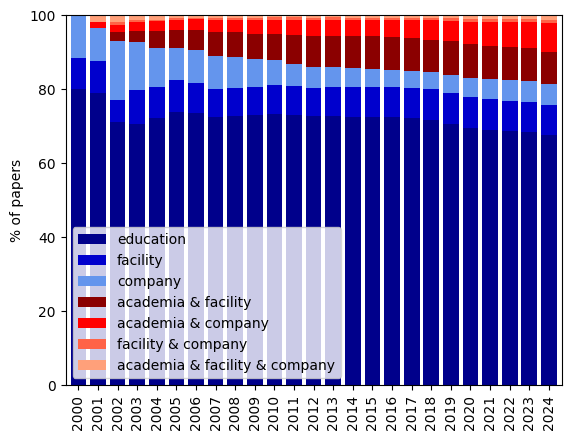

In [4]:
def plot_aff_type(typeDict):
    """
    """
    aff_df = pd.DataFrame.from_dict(typeDict, orient='index')
    my_colors = list(islice(cycle(COLOR_LIST), None, len(aff_df)))
    aff_df.plot(kind='bar', stacked=True, color=my_colors, width=.8)


    plt.ylabel('% of papers')
    plt.legend(['education','facility','company',
                'academia & facility','academia & company',
                'facility & company','academia & facility & company'])

    plt.title('')
    plt.ylim([0,100])
    plt.xticks(np.arange(25), EDITIONS, rotation=90, ha='center')
    plt.show()

plot_aff_type(typeDict)

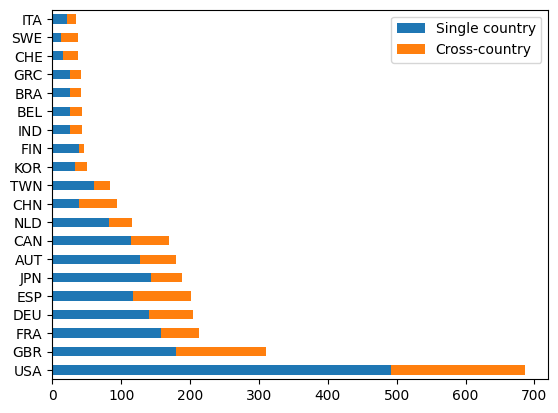

In [5]:
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))
    
def plot_aff_country():
    """
    """

    aff_df = pd.DataFrame.from_dict(CountryCountDictSorted, orient='index')
    aff_df.plot(kind='barh', stacked=True)

    # plt.ylabel('number of papers')
    plt.legend(['Single country', 'Cross-country'])
    plt.title('')
    plt.ylim([-.5,19.5])
    plt.yticks(np.arange(20), 
                         [key for key, val in take(20,CountryCountDictSorted.items())], 
                         rotation=0)
    plt.show()

plot_aff_country()


Dhekelia Sovereign Base Area not found in regex
US Naval Base Guantanamo Bay not found in regex
Siachen Glacier not found in regex
Baykonur Cosmodrome not found in regex
Akrotiri Sovereign Base Area not found in regex
Southern Patagonian Ice Field not found in regex
Bir Tawil not found in regex
Indian Ocean Territories not found in regex
Coral Sea Islands not found in regex
Spratly Islands not found in regex
Clipperton Island not found in regex
Ashmore and Cartier Islands not found in regex
Bajo Nuevo Bank (Petrel Is.) not found in regex
Serranilla Bank not found in regex
Scarborough Reef not found in regex


                      country country_code  \
0                   Indonesia          IDN   
1                    Malaysia          MYS   
2                       Chile          CHL   
3                     Bolivia          BOL   
4                        Peru          PER   
..                        ...          ...   
237                     Palau          PLW   
238                      Guam          GUM   
239  Northern Mariana Islands          MNP   
240                   Bahrain          BHR   
241               Macao S.A.R          MAC   

                                              geometry iso2_code Country  \
0    MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...        ID     NaN   
1    MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...        MY     MYS   
2    MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...        CL     NaN   
3    POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...        BO     NaN   
4    MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...        PE   

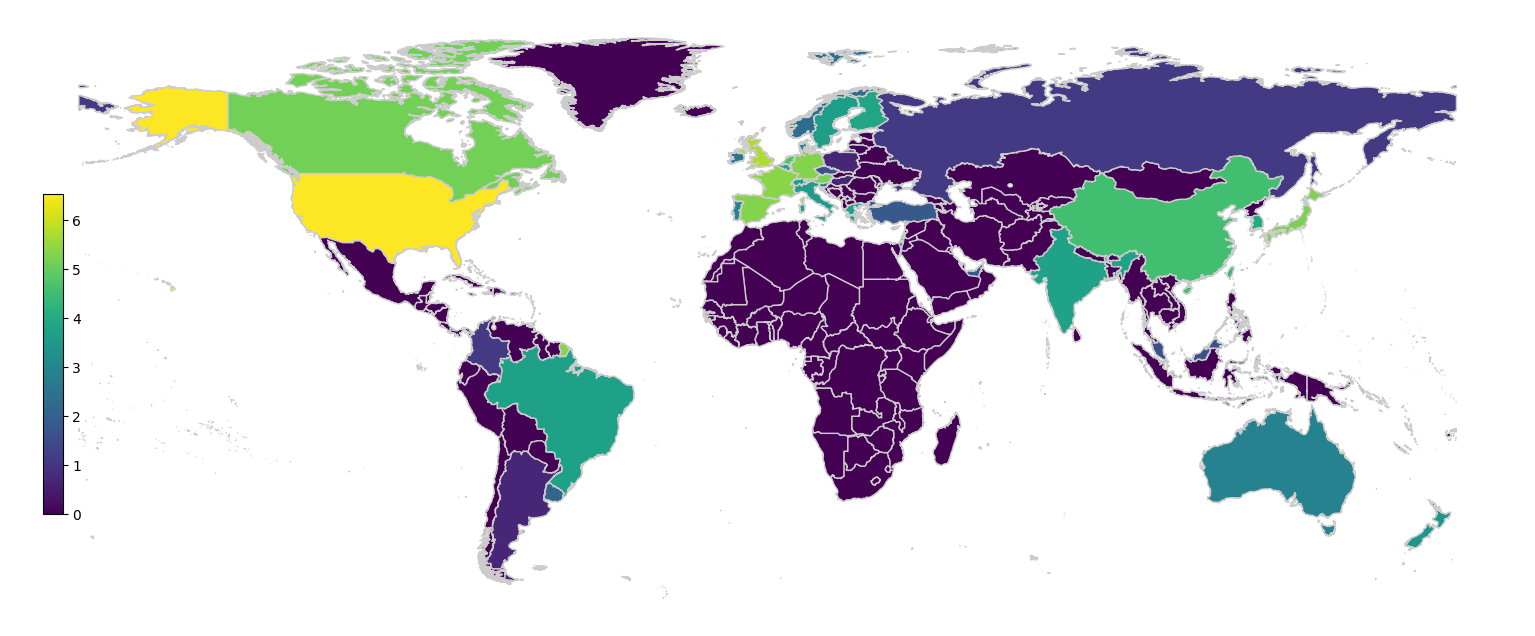

In [6]:
def plot_worldmap():
    """
    """
    # Setting the path to the shapefile
    SHAPEFILE = 'data/worldmap/ne_10m_admin_0_countries.shp'
    # Read shapefile using Geopandas
    geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]
    # Rename columns.
    geo_df.columns = ['country', 'country_code', 'geometry']
    geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)


    iso3_codes = geo_df['country'].to_list()
    # Convert to iso3_codes
    iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
    # Add the list with iso2 codes to the dataframe
    geo_df['iso2_code'] = iso2_codes_list
    # There are some countries for which the converter could not find a country code. 
    # We will drop these countries.
    geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)


    CountryCountDictPlot = {key: val for key, val in temp2 if key!="unknown"}
    country_df = pd.DataFrame(list(CountryCountDictPlot.items()), columns=['Country', 'Value'])

    merged_df = pd.merge(left=geo_df, right=country_df, how='left', left_on='country_code', right_on='Country')

    merged_df["Value"].fillna(1, inplace=True)

    merged_df["Value"] = np.log(merged_df["Value"])
    print(merged_df)

    col = 'Value'
    vmin = merged_df[col].min()
    vmax = merged_df[col].max()
    cmap = 'viridis'
    # Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(20, 8))
    # Remove the axis
    ax.axis('off')
    merged_df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
    # Empty array for the data range
    sm._A = []
    # Add the colorbar to the figure
    cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
    cbar = fig.colorbar(sm, cax=cbaxes)

    plt.show()

plot_worldmap()

## Measuring Diversity and Inequality

This section uses the data of affiliation country to measure inequality (based on the Gini index) and diversity (based on Shannon's entropy and Pielou Evenness index). We take into account a list of all countries in the list of ISO3166 country codes to calculate Gini. 

In [7]:
all_ismir = df['Affiliation country'].dropna().str.split(',').explode().str.strip().unique().tolist()
all_ismir.remove('unknown')
print(all_ismir)

full_list = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'VAT', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'XKX', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MKD', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'NIU', 'NFK', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'PCN', 'POL', 'PRT', 'PRI', 'QAT', 'REU', 'ROU', 'RUS', 'RWA', 'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'WSM', 'SMR', 'STP', 'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 'LKA', 'SDN', 'SUR', 'SJM', 'SWZ', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TLS', 'TGO', 'TKL', 'TON', 'TTO', 'TUN', 'TUR', 'TKM', 'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMI', 'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']
print(full_list)

countries = df[df['Year'] == 2001]['Affiliation country'].dropna().str.split(',').explode().str.strip()
country_counts = countries.value_counts().drop('unknown', errors='ignore').reindex(all_ismir, fill_value=0)
import numpy as np
array = np.sort(np.array(country_counts))[::-1]
index = np.arange(1, array.shape[0] + 1)
print(array, index)

['JPN', 'USA', 'GBR', 'MYS', 'FRA', 'TWN', 'GRC', 'AUS', 'DEU', 'ESP', 'POL', 'NZL', 'FIN', 'ITA', 'CAN', 'IRL', 'BEL', 'CHN', 'KOR', 'NLD', 'SVN', 'AUT', 'SGP', 'BRA', 'CHE', 'ISR', 'NOR', 'DNK', 'ROU', 'PRT', 'VEN', 'HUN', 'URY', 'SRB', 'HKG', 'IND', 'IRN', 'TUR', 'SWE', 'CYP', 'ARE', 'RUS', 'CZE', 'EST', 'COL', 'UAE', 'ARG', 'VNM']
['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY

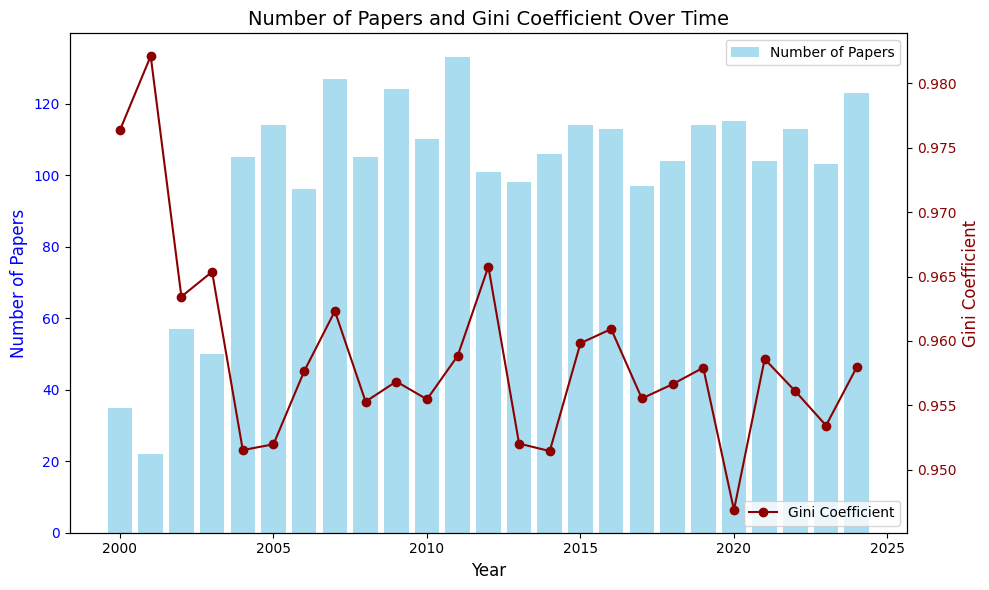

In [8]:
import seaborn as sns
import numpy as np


def gini(array):
    array = np.array(array, dtype=np.float64)
    
    if np.any(array < 0):
        raise ValueError('Negative values!')
    
    if np.sum(array) == 0:
        return 0.0  # If all values are zero, return 0

    array = np.sort(array)  
    cumulative = np.cumsum(array)
    sum_y = cumulative[-1]

    n = array.shape[0]
    gini_coeff = (2 * np.sum((np.arange(1, n + 1) * array)) / sum_y - (n + 1)) / n
    return gini_coeff


gini_data = []
for year, group in df.groupby('Year'):
    countries = group['Affiliation country'].dropna().str.split(',').explode().str.strip()
    # using full list of 250 countries to calculate Gini 
    country_counts = countries.value_counts().drop('unknown', errors='ignore').reindex(full_list, fill_value=0)
    gini_coeff = gini(country_counts)
    gini_data.append((year, gini_coeff))

gini_df = pd.DataFrame(gini_data, columns=['Year', 'Gini_Coefficient'])
yearly_counts = df['Year'].value_counts().sort_index()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(yearly_counts.index, yearly_counts.values, color='skyblue', alpha=0.7, label='Number of Papers')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Number of Papers and Gini Coefficient Over Time', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(gini_df['Year'], gini_df['Gini_Coefficient'], color='darkred', marker='o', label='Gini Coefficient')
ax2.set_ylabel('Gini Coefficient', fontsize=12, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

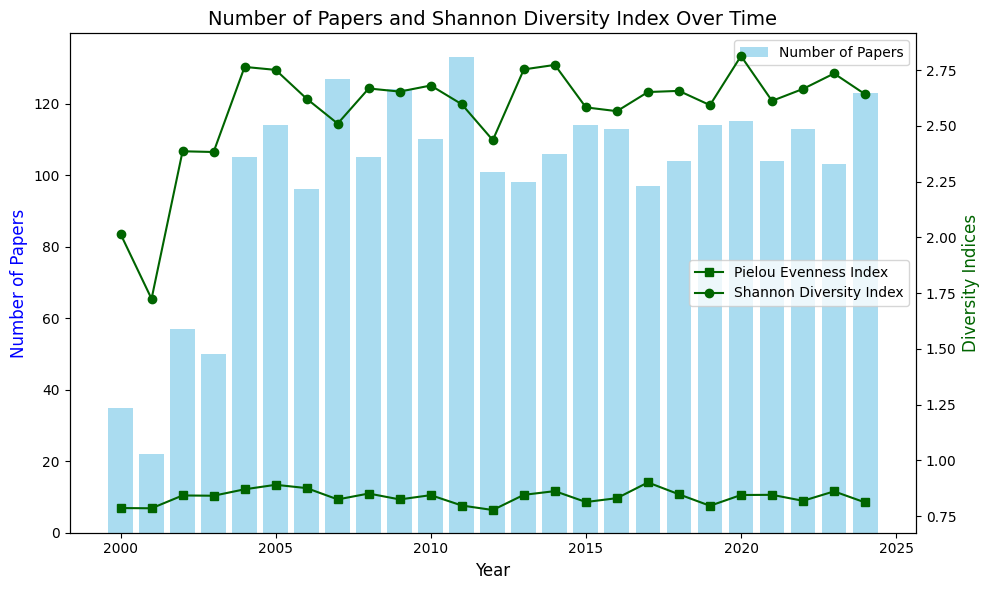

In [9]:
from scipy.stats import entropy

shannon_data = []
for year, group in df.groupby('Year'):
    countries = group['Affiliation country'].dropna().str.split(',').explode().str.strip()
    country_counts = countries.value_counts().drop('unknown', errors='ignore').reindex(all_ismir, fill_value=0)
    S = (country_counts > 0).sum()  # Number of unique countries
    shannon_ent = entropy(country_counts)
    # calculate pielou index
    pielou_evenness = shannon_ent / np.log(S) if S > 1 else np.nan
    shannon_data.append((year, shannon_ent, pielou_evenness))

shannon_df = pd.DataFrame(shannon_data, columns=['Year', 'Shannon_Diversity_Index', 'Pielou_Evenness'])

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(yearly_counts.index, yearly_counts.values, color='skyblue', alpha=0.7, label='Number of Papers')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12, color='blue')
ax1.tick_params(axis='y')
ax1.set_title('Number of Papers and Shannon Diversity Index Over Time', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(shannon_df['Year'], shannon_df['Pielou_Evenness'], color='darkgreen', marker='s', label='Pielou Evenness Index')
ax2.plot(shannon_df['Year'], shannon_df['Shannon_Diversity_Index'], color='darkgreen', marker='o', label='Shannon Diversity Index')
ax2.set_ylabel('Diversity Indices', fontsize=12, color='darkgreen')
ax2.tick_params(axis='y')

ax1.legend(loc='upper right')
ax2.legend(loc='center right')
plt.tight_layout()
plt.show()

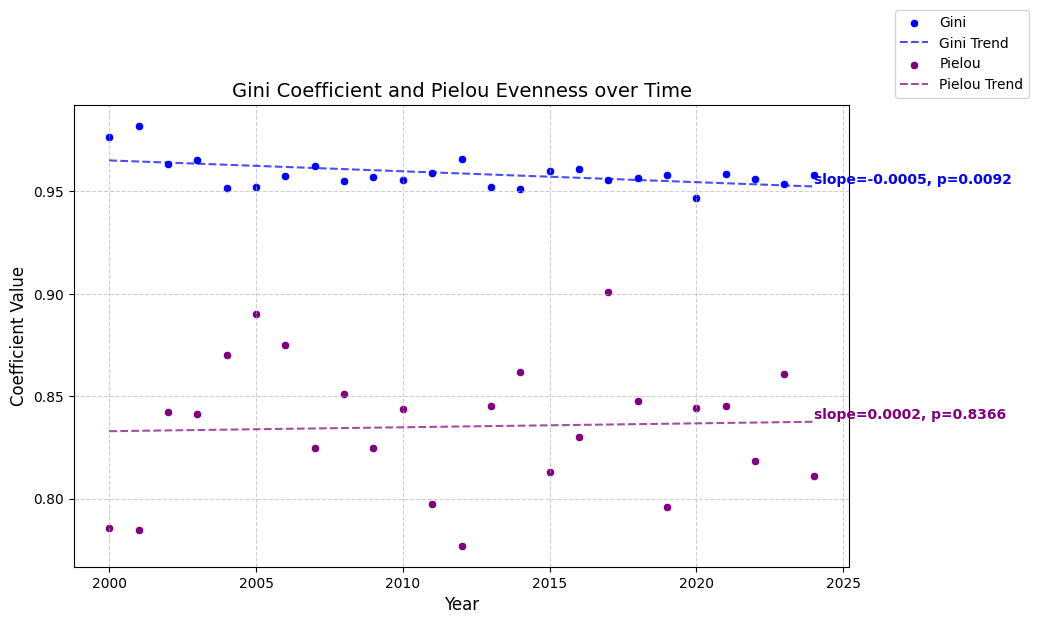

In [10]:
from scipy.stats import linregress
import seaborn as sns

combined_df = pd.merge(gini_df, shannon_df, on='Year', how='inner')
combined_df.rename(columns={'Gini_Coefficient': 'Gini', 'Shannon_Diversity_Index': 'Shannon', 'Pielou_Evenness': 'Pielou'}, inplace=True)
fig, ax = plt.subplots(figsize=(10, 6))

colors = {
    'Gini': 'blue',
    'Pielou': 'purple'
}

for col, color in colors.items():
    sns.scatterplot(x=combined_df['Year'], y=combined_df[col], label=col, color=color, ax=ax)
    slope, intercept, r_value, p_value, std_err = linregress(combined_df['Year'], combined_df[col])
    reg_line = combined_df['Year'] * slope + intercept
    ax.plot(combined_df['Year'], reg_line, color=color, linestyle='--', alpha=0.7, label=f'{col} Trend')

    last_x = combined_df['Year'].max()
    last_y = last_x * slope + intercept  # Compute last Y point
    ax.text(last_x, last_y, f'slope={slope:.4f}, p={p_value:.4f}', 
            fontsize=10, color=color, ha='left', va='bottom', fontweight='bold')
    
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Coefficient Value', fontsize=12)
ax.set_title('Gini Coefficient and Pielou Evenness over Time', fontsize=14)

ax.legend(loc='lower left', bbox_to_anchor=(1.05, 1), fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()

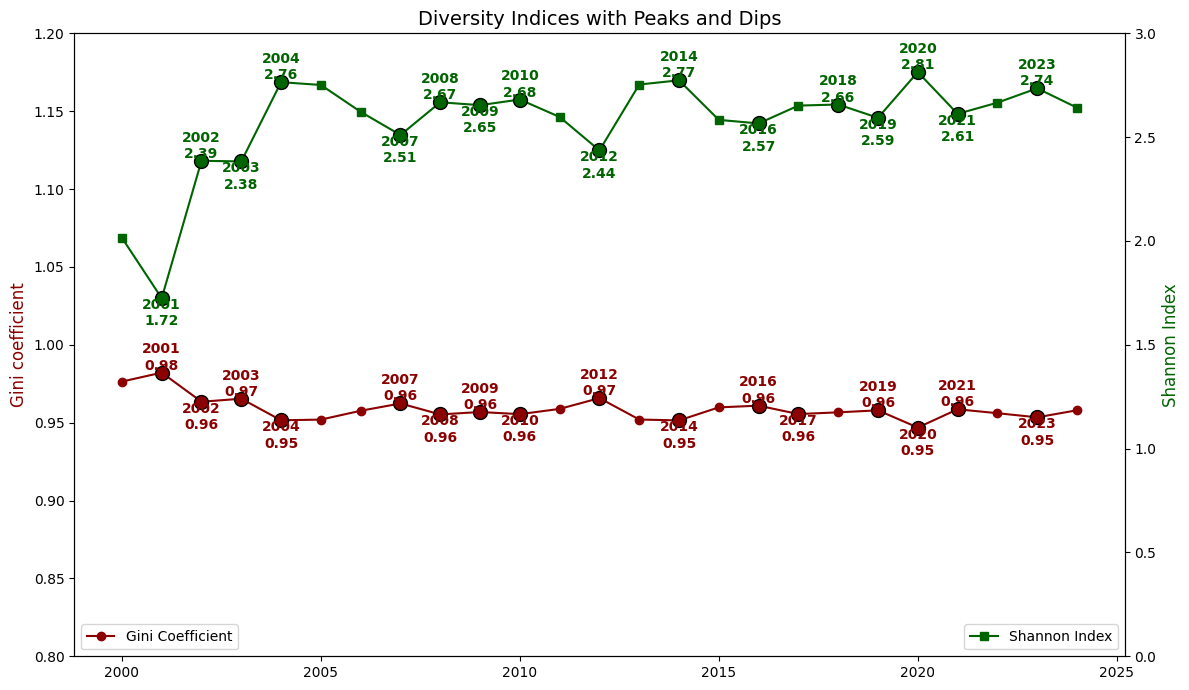

In [11]:
import scipy.signal

def find_extrema(series):
    maxima = scipy.signal.argrelextrema(series.values, np.greater)[0]  # Peaks
    minima = scipy.signal.argrelextrema(series.values, np.less)[0]  # Dips
    return series.iloc[maxima], series.iloc[minima]

gini_peaks, gini_dips = find_extrema(combined_df.set_index('Year')['Gini'])
shannon_peaks, shannon_dips = find_extrema(combined_df.set_index('Year')['Shannon'])


fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(combined_df['Year'], combined_df['Gini'], 
         color='darkred', marker='o', label='Gini Coefficient')
ax1.set_title('Diversity Indices with Peaks and Dips', fontsize=14)
for series, color, label in [(gini_peaks, 'darkred', 'Gini Peak'), 
                              (gini_dips, 'darkred', 'Gini Dip')]:
    for year, value in series.items():
        ax1.scatter(year, value, color=color, s=100, edgecolors='black', zorder=3)  # Highlight points
        ax1.text(year, value, f"{year}\n{value:.2f}", fontsize=10, 
                 ha='center', va='bottom' if 'Peak' in label else 'top', 
                 color=color, fontweight='bold')
ax1.set_ylabel('Gini coefficient', fontsize=12, color='darkred')
ax1.set_ylim([0.8, 1.2])


ax2 = ax1.twinx()
ax2.plot(combined_df['Year'], combined_df['Shannon'], 
         color='darkgreen', marker='s', label='Shannon Index')

for series, color, label in [(shannon_peaks, 'darkgreen', 'Shannon Peak'), 
                              (shannon_dips, 'darkgreen', 'Shannon Dip')]:
    for year, value in series.items():
        ax2.scatter(year, value, color=color, s=100, edgecolors='black', zorder=3)  # Highlight points
        ax2.text(year, value, f"{year}\n{value:.2f}", fontsize=10, 
                 ha='center', va='bottom' if 'Peak' in label else 'top', 
                 color=color, fontweight='bold')

ax2.set_ylabel('Shannon Index', fontsize=12, color='darkgreen')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim([0, 3])

ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

A dip in Shannon and a peak in Gini suggests increasing concentration / decreasing diversity.
- 2001, 2003, *2007*, 2009, *2012*, *2019*

A peak in Shannon and a dip in Gini suggests decreasing concentration / increasing diversity.
- 2002, 2004, *2014*, *2020*


## Network analysis
Analyze the co-authorship or affiliation networks for geographic and institutional diversity. We do bipartite networks to understand the relationship between authors and affiliations. 

In [12]:
import networkx as nx
from pyvis.network import Network

edges = []
for _, row in df.iterrows():
    authors = row['Authors'].split(';')  # Split authors
    countries = row['Affiliation country'].split(',')  # Split country codes
    for author, country in zip(authors, countries):
        edges.append((author.strip(), country.strip()))  # Add edges between authors and countries

B = nx.Graph()
B.add_edges_from(edges)

authors = {node for node, degree in B.degree if any(node in edge for edge in edges)}
countries = set(B) - authors

# compute centrality and node sizes
degree_centrality = nx.degree_centrality(B)
node_size = {node: degree_centrality[node] * 50 for node in B.nodes}  # Scale size for Pyvis
country_size = {node: degree_centrality[node] * 100 for node in countries}  # Larger size for countries

# create pyvis network
net = Network(notebook=True, height="800px", width="100%", bgcolor="#222222", font_color="white", cdn_resources='in_line')
net.force_atlas_2based(gravity=-1000, central_gravity=0.01, spring_length=100, spring_strength=0.01, damping=0.1) 

for node in B.nodes:
    color = "lightblue" if node in authors else "darkblue"  
    size = node_size.get(node, 5) + 5 
    if node in countries:
        size = country_size.get(node, 100) + 30  
        color = "lightgreen"  # Change country color for contrast

    net.add_node(
        node, 
        label=node, 
        size=size, 
        color=color,
        title=f"Node: {node}"  # Hover tooltip with node name
    )


# Step 7: Add Edges
for edge in B.edges:
    net.add_edge(*edge, color="lightblue", width=0.5)

# Step 8: Show the Network directly in Jupyter
# net.show("author_country_network.html")
net.write_html("author_country_network.html")

In [13]:
communities = nx.community.louvain_communities(B, seed=1987)
all_authors = df['Authors'].dropna().str.split(';').explode().str.strip().unique().tolist()

# Print the communities
print("Louvain Communities:")
cnt_single = 0
cnt_multi = 0
for i, comm in enumerate(communities):
    
    this_country = [_ for _ in comm if _ in all_ismir]
    th_authors = [_ for _ in comm if _ in all_authors]
    if len(this_country) > 1:
        print('-----------------------------------------------')
        print('------------Inter-country community------------')
        print('-----------------------------------------------')
        print(f'Community {this_country}:\n{th_authors}')
        cnt_multi += 1
    else:
        cnt_single += 1
    
    
    # print(f'Community {this_country}:\n{th_authors}')
print('-----------------------------------------------')
print('--------------------SUMMARY--------------------')
print('-----------------------------------------------')
print(f'Single-country communities: {cnt_single}/{i} ({cnt_single/i}%)')
print(f'Multi-country communities: {cnt_multi}/{i} ({cnt_multi/i}%)')
        


Louvain Communities:
-----------------------------------------------
------------Inter-country community------------
-----------------------------------------------
Community ['ROU', 'FIN']:
['Jarno Seppänen', 'Suvi H Saarikallio', 'Tuomas Eerola', 'Francis J. Kiernan', 'Sami Perttu', 'Antti Laaksonen', 'Jouni Paulus', 'Matti Ryynänen', 'Kjell Lemström', 'Rafael Ferrer', 'Mika Laitinen', 'Anssi Klapuri', 'Teppo E. Ahonen', 'Petri Toiviainen', 'Toni Heittola', 'Esko Ukkonen', 'Jarmo Hiipakka', 'Annamaria Mesaros', 'Tuomas Virtanen', 'Niko Mikkilä', 'M. Turkia', 'Antti J. Eronen', 'Timo Sorsa', 'Katriina Halonen', 'José Fornari', 'Emily Carlson', 'Mikael Laurson', 'Otso Björklund', 'Mika Kuuskankare', 'Pasi Saari', 'Jaakko Astola', 'Teemu Tuomas Ahmaniemi', 'Simo Linkola', 'Anna Pienimäki', 'Veli Mäkinen']
-----------------------------------------------
------------Inter-country community------------
-----------------------------------------------
Community ['NLD', 'CYP', 'EST']:
['Marië

It seems that very few affiliations are able to trascend single-country communities. Moreover, most of the multi-country communities are very focused in Europe: Romania-Finland, Estonia-Cyprus-Netherlands, Denmark-Norway-Portugal , Italy-Austria

Other non-western communities are United Arab Emirates-Greece-Turkey, and Uruguay-Spain.

# Wordclouds

This could be related more to general topics as discussed by Perfecto Herrera in his PhD Thesis:
- 2000-2004: age of feature extractors
- 2004-2009: age of semantic content
- 2009-2014: age of context-aware systems
- 2014-today: age of creative systems


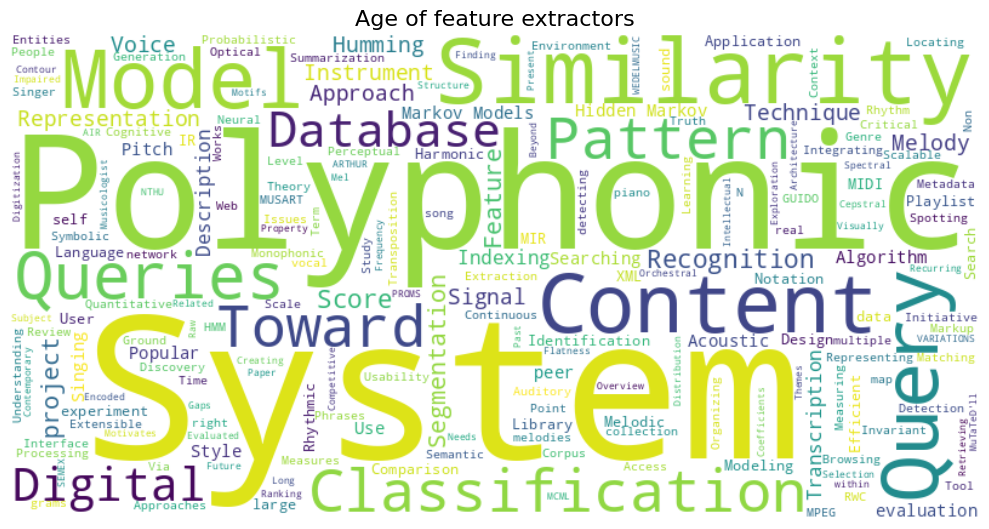

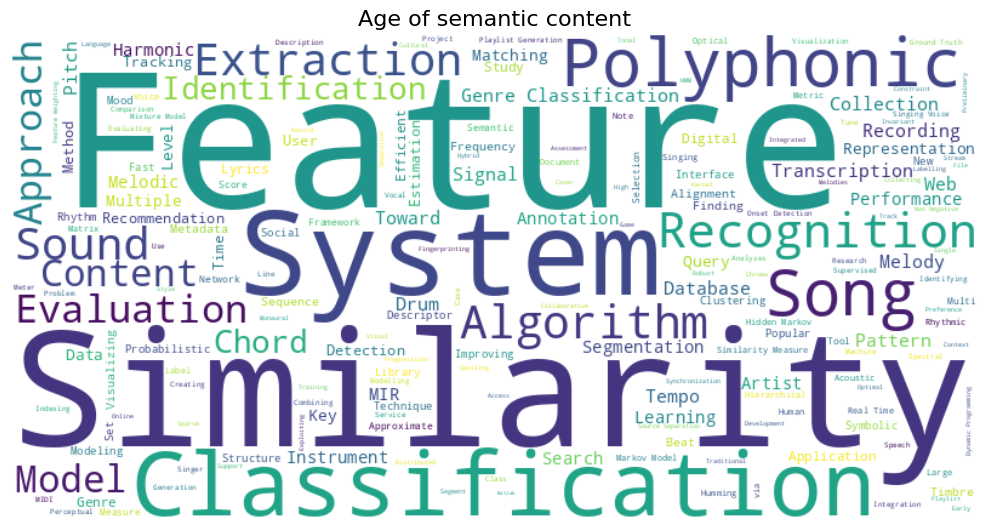

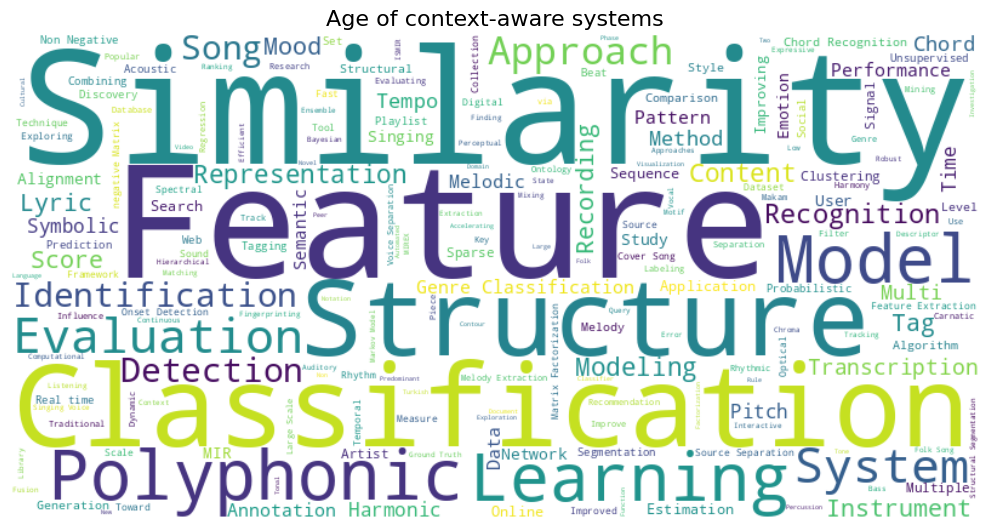

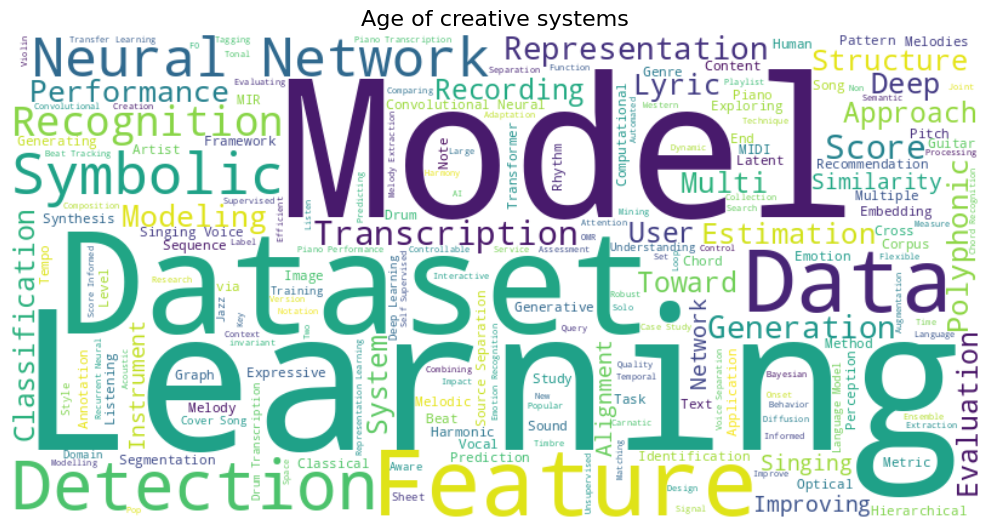

In [14]:
from wordcloud import WordCloud, STOPWORDS

custom_stopwords = set(['music', 'audio', 'using', 'musical', 'retrieval', 'analysis', 'based', 'automatic', 'information'])
stopwords = STOPWORDS.union(custom_stopwords)

df_1 = df[(df['Year'] >= 2000) & (df['Year'] < 2004)]
df_2 = df[(df['Year'] >= 2004) & (df['Year'] < 2009)]
df_3 = df[(df['Year'] >= 2009) & (df['Year'] < 2014)]
df_4 = df[(df['Year'] >= 2014) & (df['Year'] < 2025)]

text_ttl_1 = ' '.join(df_1['Title'].dropna().tolist())
text_ttl_2 = ' '.join(df_2['Title'].dropna().tolist())
text_ttl_3 = ' '.join(df_3['Title'].dropna().tolist())
text_ttl_4 = ' '.join(df_4['Title'].dropna().tolist())

wordcloud_ttl_1 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text_ttl_1)
wordcloud_ttl_2 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text_ttl_2)
wordcloud_ttl_3 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text_ttl_3)
wordcloud_ttl_4 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text_ttl_4)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_ttl_1, interpolation='bilinear')
plt.axis('off')
plt.title('Age of feature extractors', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_ttl_2, interpolation='bilinear')
plt.axis('off')
plt.title('Age of semantic content', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_ttl_3, interpolation='bilinear')
plt.axis('off')
plt.title('Age of context-aware systems', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_ttl_4, interpolation='bilinear')
plt.axis('off')
plt.title('Age of creative systems', fontsize=16)
plt.tight_layout()
plt.show()